# Bayesian logistic regression using Mici

In [1]:
from functools import partial
import numpy as np
import mici
import arviz
import corner
import matplotlib.pyplot as plt

In [2]:
data = dict(np.load("data.npz"))

## Manually implemented gradient using NumPy

In [3]:
def neg_log_posterior_dens(beta, data):
    return (
        (beta**2).sum() / (2 * data["alpha"]**2) 
        + np.log1p(np.exp(-(2 * data["y"] - 1) * (beta @ data["X"]))).sum()
    )

def grad_neg_log_posterior_dens(beta, data):
    z = 1 - 2 * data["y"]
    exp_z_beta_X = np.exp(z * (beta @ data["X"]))
    # Mici optionally allows gradient function to return both gradient and value as a tuple
    return (
        beta / data["alpha"]**2 + ((z * data["X"] * exp_z_beta_X) / (1 + exp_z_beta_X)).sum(-1), 
        (beta**2).sum() / (2 * data["alpha"]**2) + np.log1p(exp_z_beta_X).sum()
    )


In [4]:
seed = 20220217
rng = np.random.default_rng(seed)
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=partial(neg_log_posterior_dens, data=data), 
    grad_neg_log_dens=partial(grad_neg_log_posterior_dens, data=data)
)
integrator = mici.integrators.LeapfrogIntegrator(system)
sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.8),
    mici.adapters.OnlineCovarianceMetricAdapter()
]

In [5]:
def trace_func(state):
    return {"beta": state.pos, "neg_log_posterior_dens": system.neg_log_dens(state)}

In [6]:
n_chain = 4
initial_states = [rng.standard_normal(data["dim_beta"]) * data["alpha"] for _ in range(n_chain)]

In [7]:
final_state, traces, stats = sampler.sample_chains(
    n_warm_up_iter=1000, 
    n_main_iter=1000,
    init_states=initial_states,
    adapters=adapters,
    trace_funcs=[trace_func],
    n_process=n_chain,
    monitor_stats=["accept_stat", "step_size", "n_step"]
)

Sampling stage: Initial fast adaptive [00:19] > Slow adaptive (1/5) [00:05] > Slow adaptive (2/5) [00:22] > Slow adaptive (3/5) [00:23] > Slow adaptive (4/5) [00:41] > Slow adaptive (5/5) [01:13] > Final fast adaptive [00:07] > Main non-adaptive [02:02]

Chain 1/4: 100%|██████████|1000/1000 [02:01<00:00, 8.26it/s, accept_stat=0.876, step_size=0.543, n_step=7.00]

Chain 2/4: 100%|██████████|1000/1000 [02:02<00:00, 8.20it/s, accept_stat=0.875, step_size=0.543, n_step=7.00]

Chain 3/4: 100%|██████████|1000/1000 [02:00<00:00, 8.33it/s, accept_stat=0.871, step_size=0.543, n_step=7.00]

Chain 4/4: 100%|██████████|1000/1000 [01:59<00:00, 8.36it/s, accept_stat=0.873, step_size=0.543, n_step=7.00]

/tmp/ipykernel_29782/1365126486.py:9: RuntimeWarning: overflow encountered in exp
  exp_z_beta_X = np.exp(z * (beta @ data["X"]))
/tmp/ipykernel_29782/1365126486.py:12: RuntimeWarning: overflow encountered in multiply
  beta / data["alpha"]**2 + ((z * data["X"] * exp_z_beta_X) / (1 + exp_z_beta_X)).sum(-1),
/tmp/ipykernel_29782/1365126486.py:9: RuntimeWarning: overflow encountered in exp
  exp_z_beta_X = np.exp(z * (beta @ data["X"]))
/tmp/ipykernel_29782/1365126486.py:12: RuntimeWarning: invalid value encountered in true_divide
  beta / data["alpha"]**2 + ((z * data["X"] * exp_z_beta_X) / (1 + exp_z_beta_X)).sum(-1),
/tmp/ipykernel_29782/1365126486.py:12: RuntimeWarning: overflow encountered in multiply
  beta / data["alpha"]**2 + ((z * data["X"] * exp_z_beta_X) / (1 + exp_z_beta_X)).sum(-1),
/tmp/ipykernel_29782/1365126486.py:12: RuntimeWarning: invalid value encountered in true_divide
  beta / data["alpha"]**2 + ((z * data["X"] * exp_z_beta_X) / (1 + exp_z_beta_X)).sum(-1),
/tmp/ipy

In [8]:
arviz.summary(traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],12.314,0.735,10.899,13.701,0.010,0.007,5767.0,3349.0,1.0
beta[1],3.083,0.214,2.667,3.477,0.003,0.002,6160.0,3117.0,1.0
beta[2],0.177,0.106,-0.020,0.378,0.001,0.001,7643.0,3186.0,1.0
beta[3],2.599,0.185,2.253,2.941,0.002,0.002,6677.0,3526.0,1.0
beta[4],6.490,0.397,5.698,7.213,0.005,0.004,5982.0,3099.0,1.0
beta[5],10.935,0.655,9.663,12.133,0.009,0.006,5276.0,3080.0,1.0
beta[6],11.456,0.677,10.169,12.728,0.009,0.006,5754.0,3179.0,1.0
beta[7],6.831,0.415,6.050,7.602,0.005,0.004,6000.0,2951.0,1.0
beta[8],2.025,0.160,1.724,2.321,0.002,0.001,6759.0,3327.0,1.0
beta[9],7.011,0.427,6.169,7.803,0.005,0.004,6219.0,2811.0,1.0


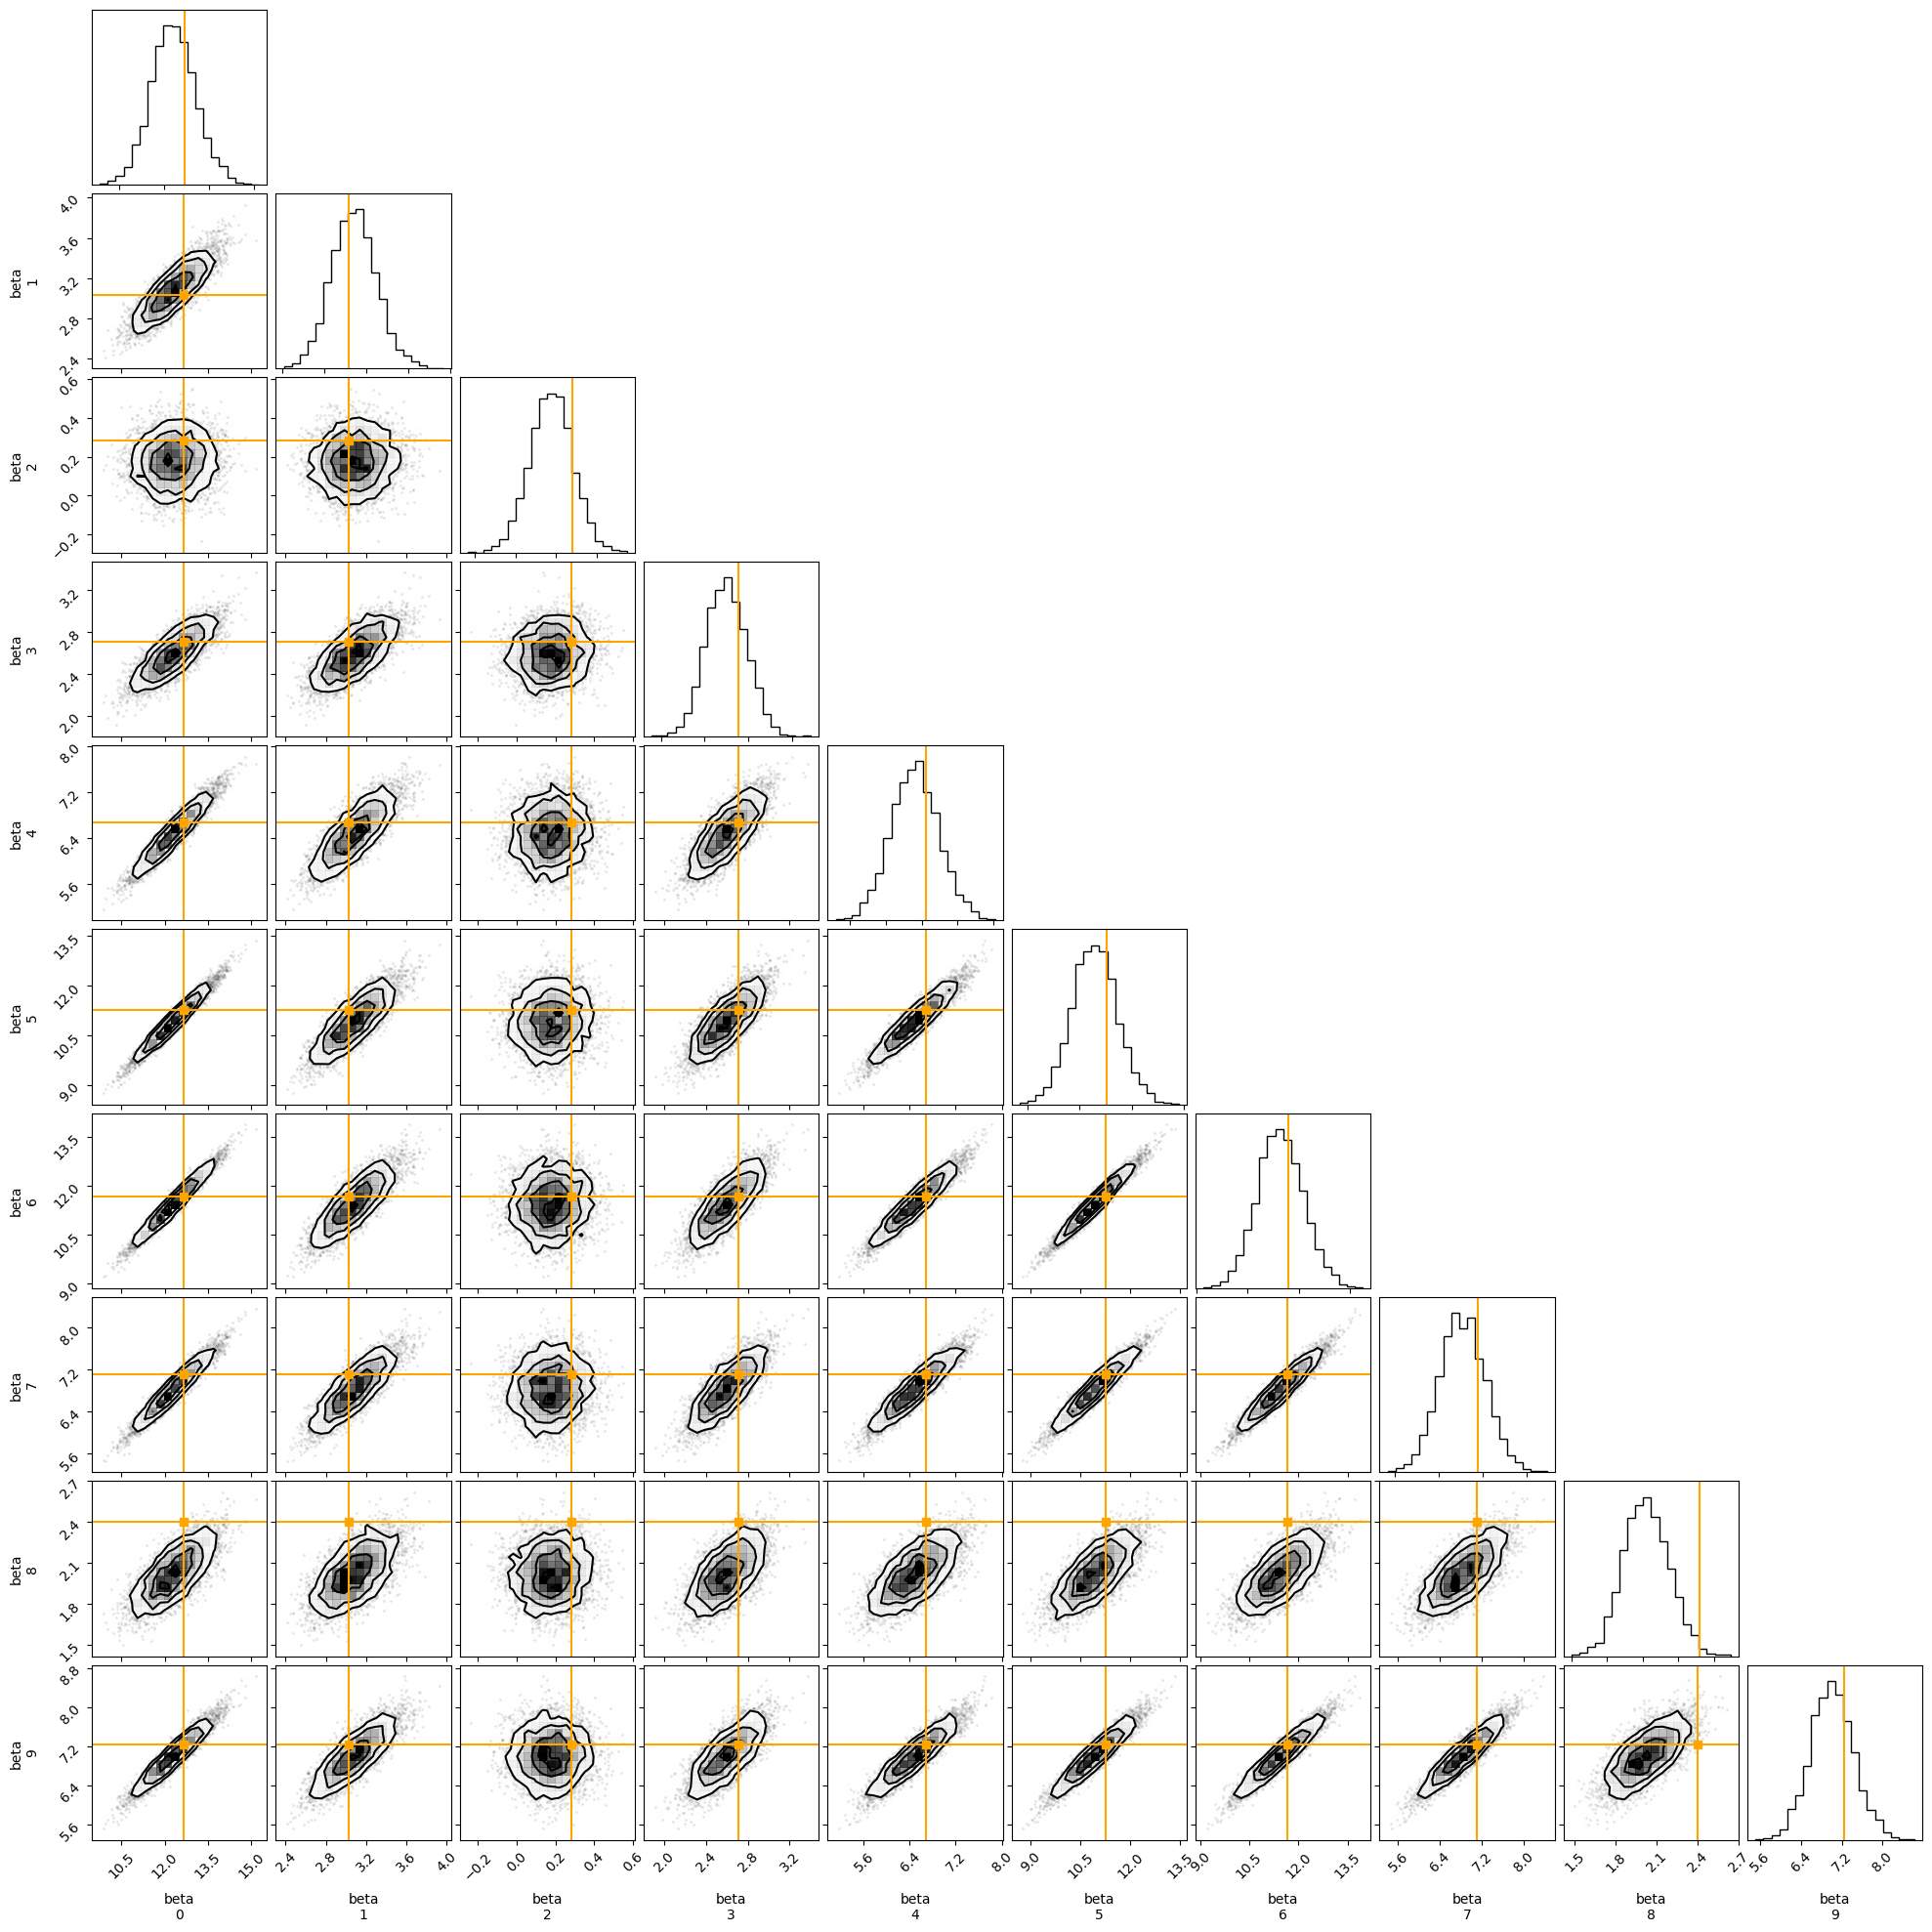

In [9]:
number_dim_to_plot = 10
fig, axes = plt.subplots(
    number_dim_to_plot,
    number_dim_to_plot,
    figsize=(2 * number_dim_to_plot, 2 * number_dim_to_plot), 
    dpi=100
)
_ = corner.corner(
    traces,
    fig=fig,
    var_names="beta",
    coords={"beta_dim_0": list(range(number_dim_to_plot))},
    truths=data["true_beta"][:number_dim_to_plot],
    truth_color="orange"
)

## Automatic differentiation using JAX

In [10]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

In [11]:
def neg_log_posterior_dens(beta, data):
    return (
        (beta**2).sum() / (2 * data["alpha"]**2) 
        + jnp.log1p(jnp.exp(-(2 * data["y"] - 1) * (beta @ data["X"]))).sum()
    )

value_and_grad_neg_log_posterior_dens = jax.jit(jax.value_and_grad(neg_log_posterior_dens))

def grad_neg_log_posterior_dens(beta, data):
    nld, grad = value_and_grad_neg_log_posterior_dens(beta, data)
    # Mici optionally allows gradient function to return both gradient and value as a tuple
    return np.asarray(grad), nld


In [12]:
seed = 20220217
rng = np.random.default_rng(seed)
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=partial(neg_log_posterior_dens, data=data), 
    grad_neg_log_dens=partial(grad_neg_log_posterior_dens, data=data)
)
integrator = mici.integrators.LeapfrogIntegrator(system)
sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.8),
    mici.adapters.OnlineCovarianceMetricAdapter()
]

In [13]:
final_state, traces, stats = sampler.sample_chains(
    n_warm_up_iter=1000, 
    n_main_iter=1000,
    init_states=initial_states,
    adapters=adapters,
    trace_funcs=[trace_func],
    n_process=n_chain,
    monitor_stats=["accept_stat", "step_size", "n_step"]
)

Sampling stage: Initial fast adaptive [00:03] > Slow adaptive (1/5) [00:01] > Slow adaptive (2/5) [00:07] > Slow adaptive (3/5) [00:04] > Slow adaptive (4/5) [00:06] > Slow adaptive (5/5) [00:12] > Final fast adaptive [00:02] > Main non-adaptive [01:22]

Chain 1/4: 100%|██████████|1000/1000 [01:22<00:00, 12.15it/s, accept_stat=0.864, step_size=0.570, n_step=7.00]

Chain 2/4: 100%|██████████|1000/1000 [01:19<00:00, 12.51it/s, accept_stat=0.864, step_size=0.570, n_step=7.00]

Chain 3/4: 100%|██████████|1000/1000 [01:22<00:00, 12.09it/s, accept_stat=0.855, step_size=0.570, n_step=7.00]

Chain 4/4: 100%|██████████|1000/1000 [01:22<00:00, 12.15it/s, accept_stat=0.866, step_size=0.570, n_step=7.00]

In [14]:
arviz.summary(traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],12.310,0.734,10.903,13.670,0.008,0.006,8728.0,2596.0,1.0
beta[1],3.082,0.217,2.668,3.483,0.002,0.002,9823.0,2760.0,1.0
beta[2],0.175,0.105,-0.022,0.371,0.001,0.001,8125.0,3083.0,1.0
beta[3],2.600,0.186,2.244,2.942,0.002,0.001,7777.0,3051.0,1.0
beta[4],6.489,0.395,5.736,7.226,0.004,0.003,8559.0,2743.0,1.0
beta[5],10.933,0.651,9.661,12.123,0.007,0.005,8541.0,2709.0,1.0
beta[6],11.453,0.675,10.147,12.705,0.007,0.005,8464.0,3013.0,1.0
beta[7],6.828,0.417,6.068,7.635,0.004,0.003,8721.0,2713.0,1.0
beta[8],2.026,0.159,1.730,2.326,0.002,0.001,9465.0,2891.0,1.0
beta[9],7.011,0.424,6.183,7.798,0.005,0.003,8545.0,2813.0,1.0


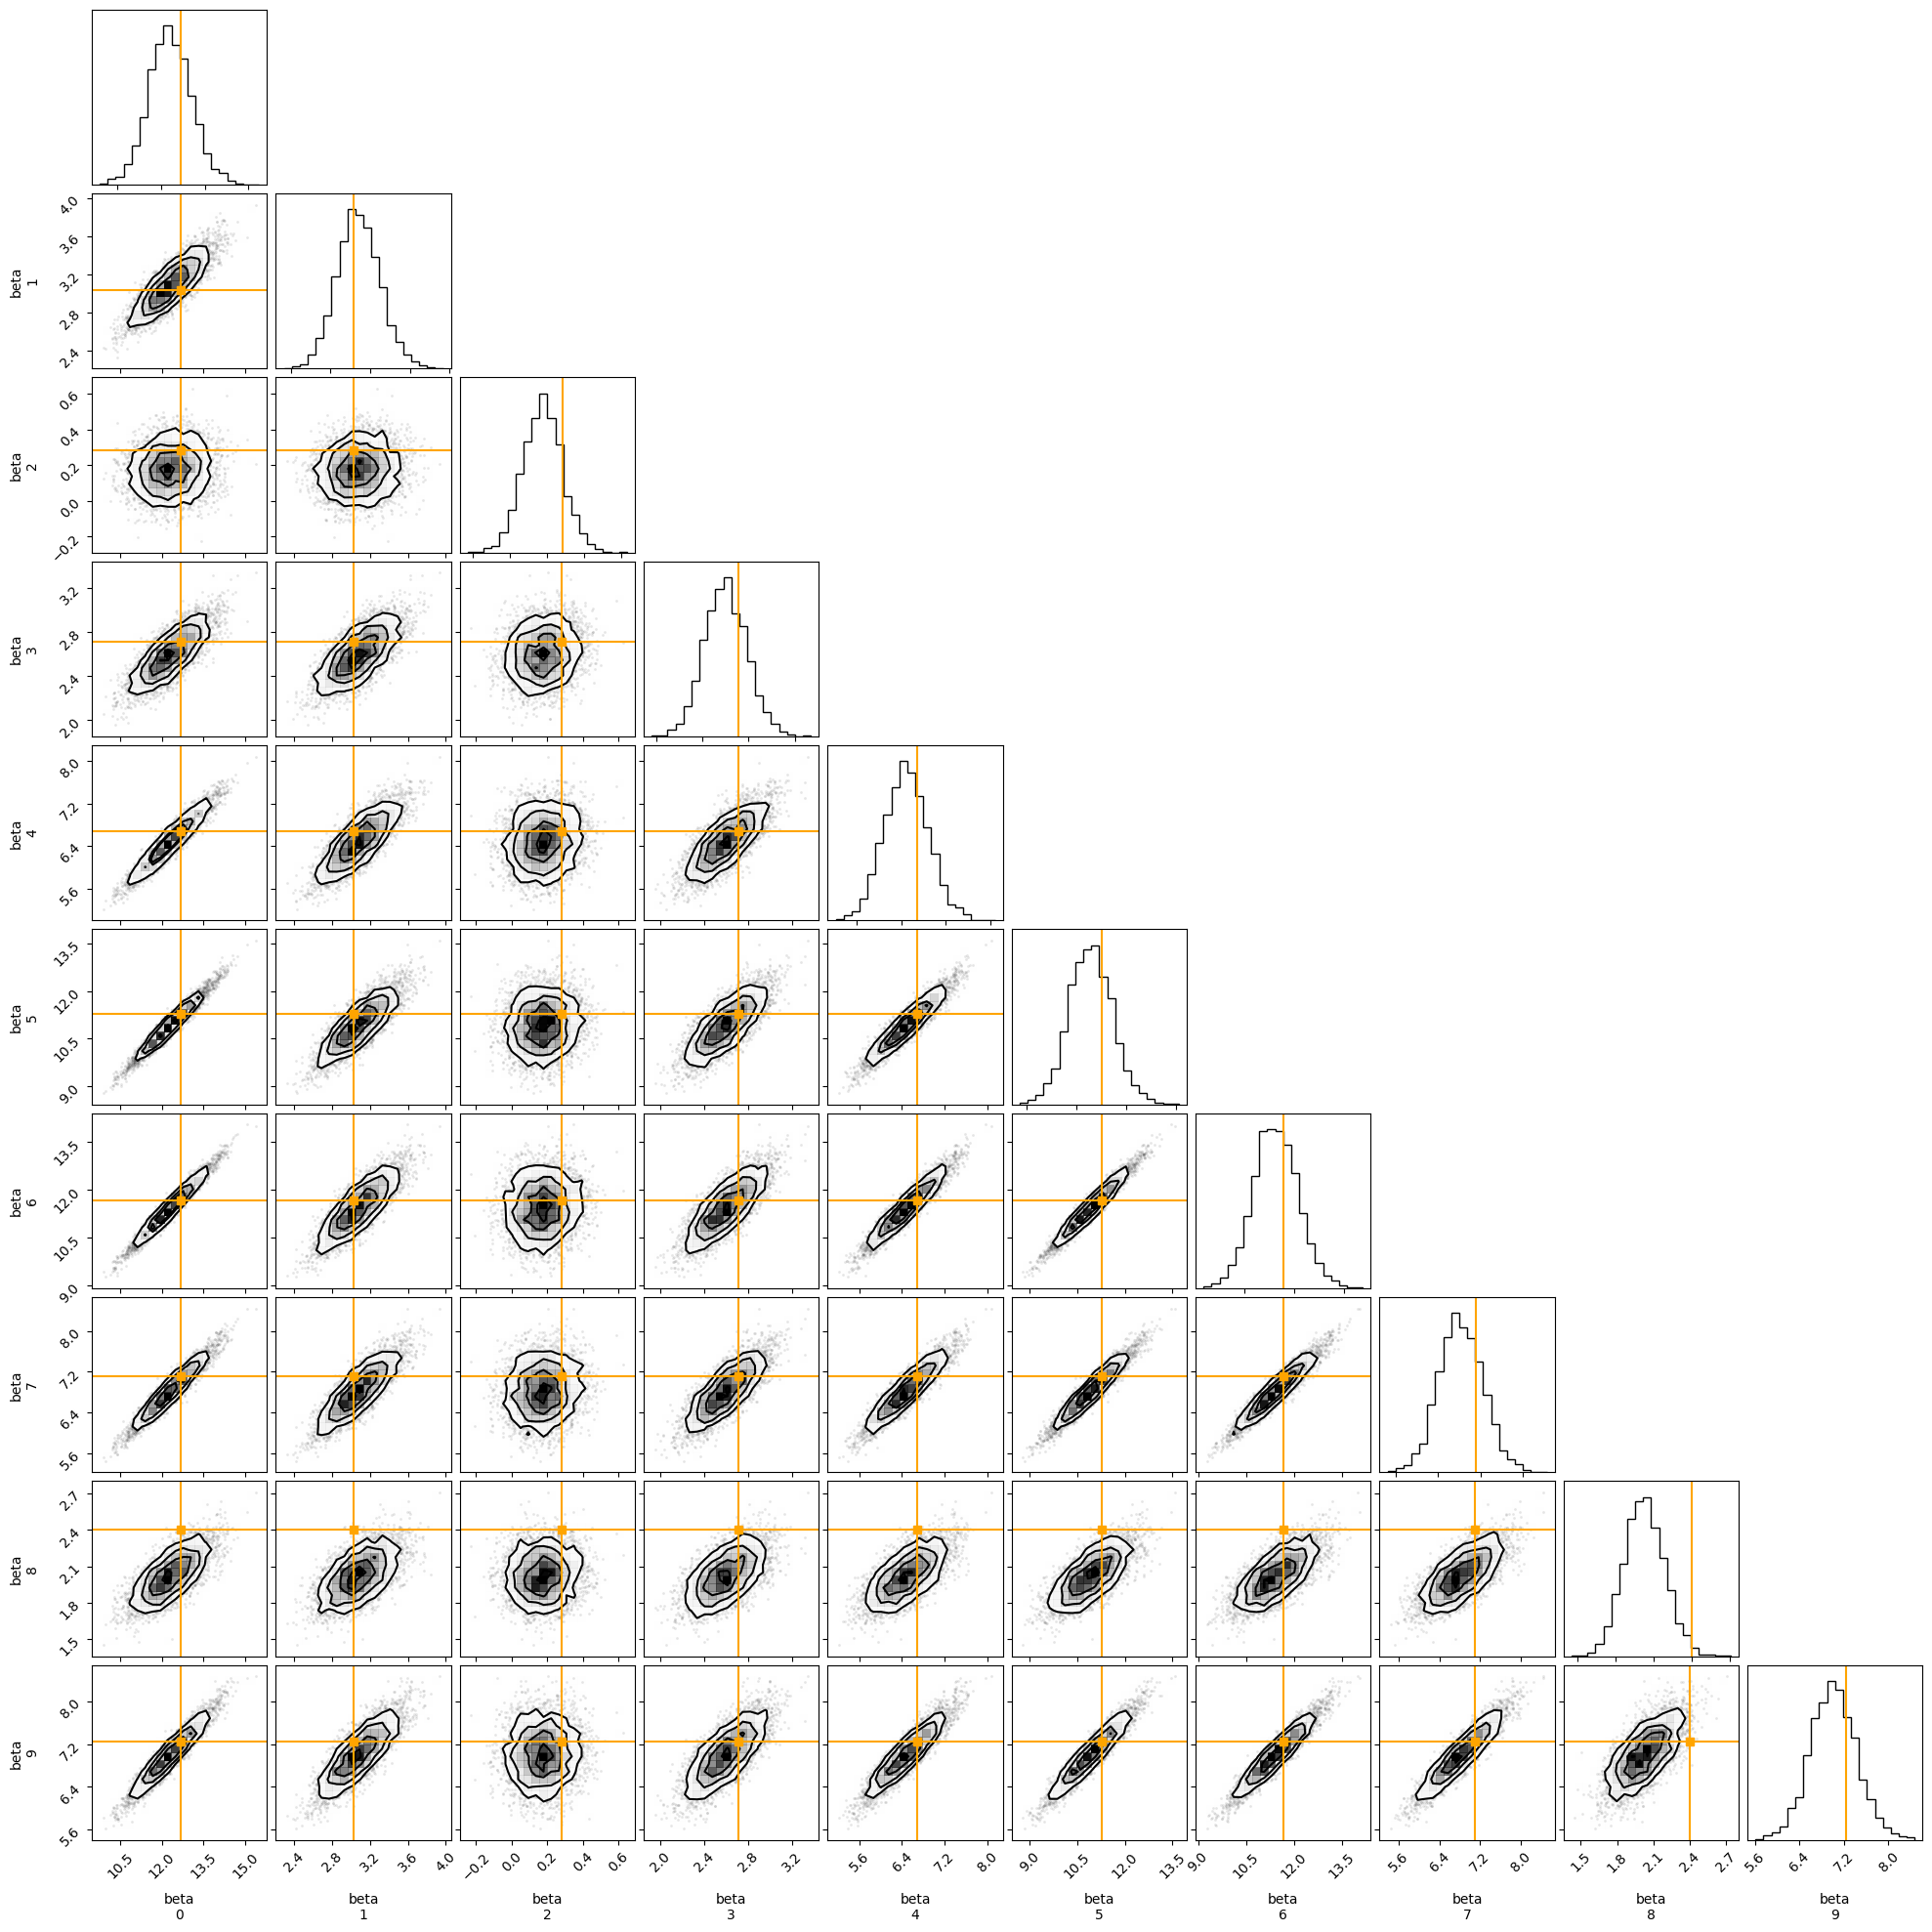

In [15]:
number_dim_to_plot = 10
fig, axes = plt.subplots(
    number_dim_to_plot,
    number_dim_to_plot,
    figsize=(2 * number_dim_to_plot, 2 * number_dim_to_plot), 
    dpi=100
)
_ = corner.corner(
    traces,
    fig=fig,
    var_names="beta",
    coords={"beta_dim_0": list(range(number_dim_to_plot))},
    truths=data["true_beta"][:number_dim_to_plot],
    truth_color="orange"
)